In [1]:
import os
import datetime
import requests
import zipfile
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import pacf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
%matplotlib inline

# Overview

Time series forecasting is a large and complicated arena - opportunities for mistakes abound. That said, we will try to touch on some of the core points to keep in mind when engaging in such modeling. These points include:
- basic considerations for temporal data
- variable relationships
- feature engineering
- predictive model validation

Rob Hyndman has written a nice book on time series forecasting (albeit with examples in R), which you can find [here](https://otexts.com/fpp2/).

# 0. Get Data

We will be using free data from a website called QuantQuote. This dataset contains daily pricing data for all S&P 500 members as of August 2013, which is where the dataset ends. For each member, the data begins when that stock entered the index. We can programmatically download and extract it.

In [3]:
def get_data(data_url):
    with requests.get(data_url) as r:

        with zipfile.ZipFile(io.BytesIO(r.content)) as z:
            z.extractall()

In [4]:
data_url = "http://quantquote.com/files/quantquote_daily_sp500_83986.zip"

In [5]:
get_data(data_url=data_url)

In [6]:
data_dir = os.path.join("quantquote_daily_sp500_83986", "daily")

In [7]:
len(os.listdir(data_dir))

500

In [8]:
def get_csv_path(csv_name, stock_csv_folder=data_dir):
    return os.path.join(stock_csv_folder, csv_name)

In [9]:
cols = ['date', 'time', 'open', 'high', 'low_price', 'close', 'volume']

In [10]:
def get_df(csv_name, cols=cols):
    df = pd.read_csv(get_csv_path(csv_name),
                     names=cols,
                     usecols=list(filter(lambda c: c!= "time", cols)))
    
    df.date = pd.to_datetime(df.date.astype(str), infer_datetime_format=True)

    return df.set_index("date", drop=False)

In [11]:
aapl_df = get_df("table_aapl.csv")

In [12]:
aapl_df.head()

,date,open,high,low_price,close,volume
date,,,,,,
1998-01-02,1998-01-02,3.31397,3.95098,3.28236,3.95098,24947201.10
1998-01-05,1998-01-05,4.01177,4.02635,3.69325,3.89020,22344145.08
1998-01-06,1998-01-06,3.87561,4.98432,3.58628,4.60502,63150252.55
1998-01-07,1998-01-07,4.57341,4.68040,4.20871,4.24032,36978255.52
1998-01-08,1998-01-08,4.24032,4.52965,4.11875,4.39107,27687622.95


# 1. Exploratory Analysis

Gaining an understanding of your data is key; a big part of this is data visualization. We will also transform our data - smoothing, rescaling, and aggregating it - to get a better sense of what is driving it.

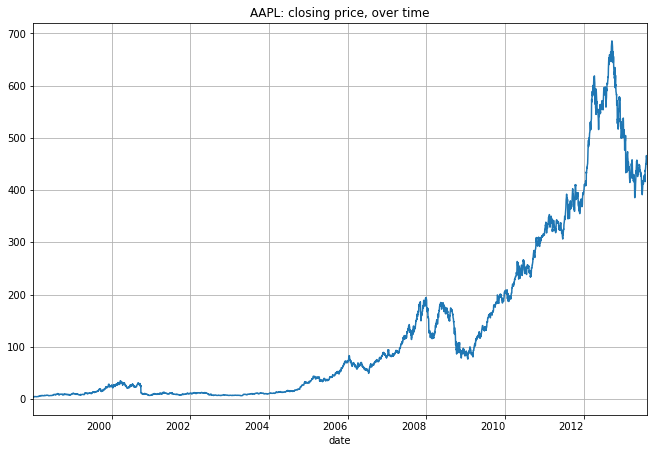

In [13]:
ax = aapl_df.close.plot(figsize=(11, 8), rot=0)
g = ax.grid(True)
t = ax.title.set_text("AAPL: closing price, over time")

### **Unit Root**

A real treatment of this concept is outside of our scope today, but you can read more about it [here](https://en.wikipedia.org/wiki/Unit_root) or [here](https://faculty.chicagobooth.edu/ruey.tsay/teaching/uts/lec11-08.pdf). For now, I'll go ahead and collquially summarize the _unit root_ concept with the following ...

Many statistical models require the assumption of certain distributional properties in the data. A key assumption is that of [*stationarity*](https://en.wikipedia.org/wiki/Stationary_process), which (among other things) means that the _mean_ and _variance_ of the data do not change over time.

If you are looking at the original and not relative-change values of your data, the data's distributional parameters, i.e. _mean_ and _variance_ are likely going to change, depending on how you slice into the data.

On the other hand, if your data follows a stationary process, the way in which it _changes_ should itself not be changing. Maybe a way to think of this is: we want to model the process, or the changes in the data, and not the data's initial conditions. If you don't make take this into account, you can get some very warped results.

Thus, something you'll often see is a change from the original values to the proportionate changes, with respect to the previous period(s). In finance, that means looking at _returns_ as opposed to _prices_.

### Prices -> Returns

In [14]:
aapl_df["return_daily"] = aapl_df.close.pct_change()

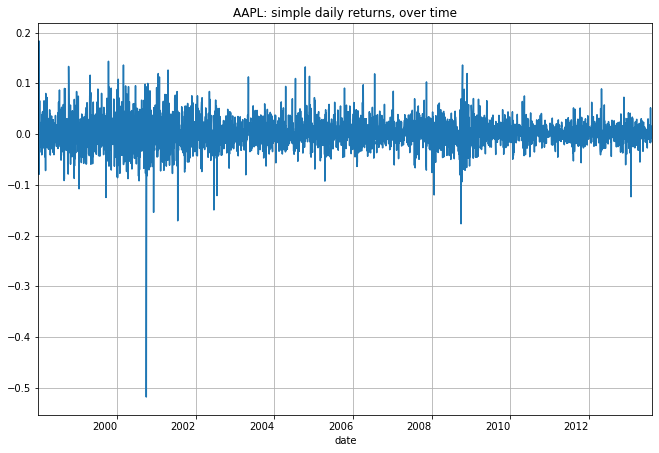

In [15]:
ax = aapl_df.return_daily.plot(figsize=(11, 8), rot=0)
g = ax.grid(True)
t = ax.title.set_text("AAPL: simple daily returns, over time")

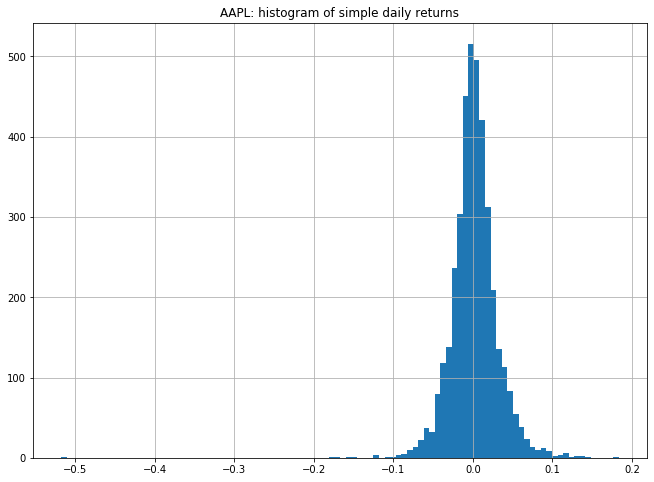

In [16]:
ax = aapl_df.return_daily.hist(bins=100, figsize=(11, 8))
g = ax.grid(True)
t = ax.title.set_text("AAPL: histogram of simple daily returns")

### Autocorrelation

An important component of time series analysis and forecasting is that of checking for _autocorrelation_, or the correlation between a time series and previous versions of itself. This can be helpful in figuring out how to model a given time series.

In [17]:
aapl_df.return_daily.rename("t"
                   ).to_frame(
                   ).join(
                        aapl_df.return_daily.shift(1).rename("t-1")
                   ).corr()

,t,t-1
t,1.000000,-0.034992
t-1,-0.034992,1.000000


### --

### Problem

- get _autocorrelation_ going back through 30 lags
- plot the results - make sure to label your plot

### --

### Multi-Period Returns

The simple return can be written as $$ \large \frac{X_{t} - X_{t - 1}}{X_{t- t}}$$

We can make a small modification to the simple return such that we do not subtract the previous period's value out and instead just take the ratio between current and previous $$ \large \frac{X_{t}}{X_{t- t}}$$

This structure allows us to easily calculate multi-period returns.

### Monthly Returns

In [19]:
aapl_df["year"] = aapl_df.date.dt.year

In [20]:
aapl_df["month"] = aapl_df.date.dt.month

In [21]:
aapl_df["return_daily_gross"] = aapl_df.return_daily + 1

In [22]:
aapl_df.head()

,date,open,high,low_price,close,volume,return_daily,year,month,return_daily_gross
date,,,,,,,,,,
1998-01-02,1998-01-02,3.31397,3.95098,3.28236,3.95098,24947201.10,NaN,1998,1,NaN
1998-01-05,1998-01-05,4.01177,4.02635,3.69325,3.89020,22344145.08,-0.015384,1998,1,0.984616
1998-01-06,1998-01-06,3.87561,4.98432,3.58628,4.60502,63150252.55,0.183749,1998,1,1.183749
1998-01-07,1998-01-07,4.57341,4.68040,4.20871,4.24032,36978255.52,-0.079196,1998,1,0.920804
1998-01-08,1998-01-08,4.24032,4.52965,4.11875,4.39107,27687622.95,0.035552,1998,1,1.035552


In [23]:
aapl_monthly = aapl_df.groupby(["year", "month"]).return_daily_gross.prod()

In [24]:
aapl_monthly.shape

(188,)

In [25]:
aapl_monthly = aapl_monthly.rename("return_t")

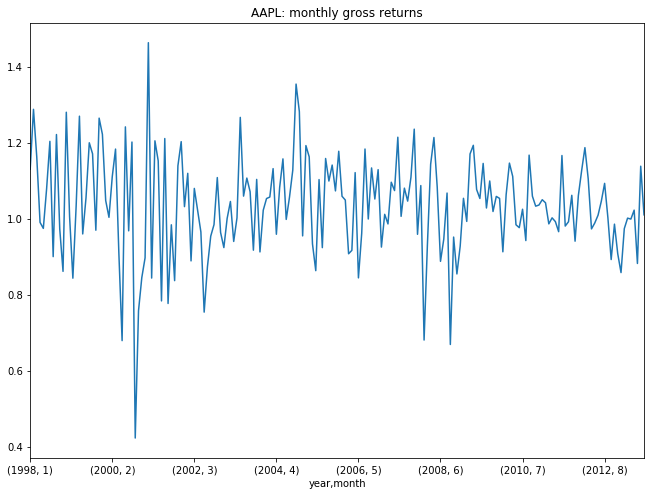

In [26]:
ax = aapl_monthly.plot(figsize=(11, 8))
t = ax.set_title("AAPL: monthly gross returns")

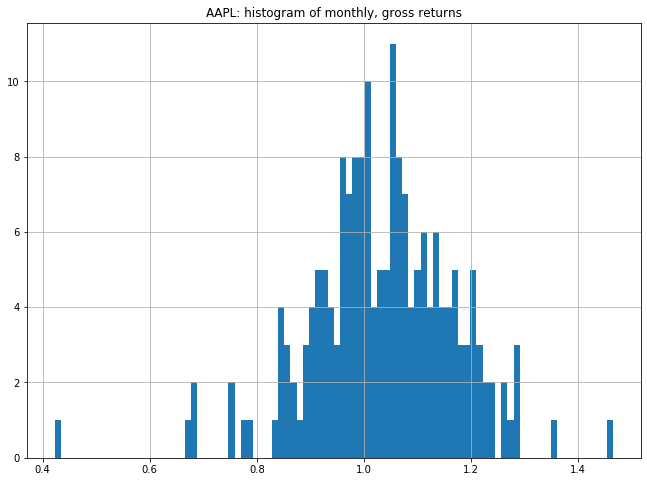

In [27]:
ax = aapl_monthly.hist(bins=90, figsize=(11, 8))
t = ax.title.set_text("AAPL: histogram of monthly, gross returns")

In [28]:
aapl_monthly = aapl_monthly.to_frame()

### Rolling

#### Cumulative

In [29]:
aapl_df["return_cumulative_30_day"] = aapl_df.return_daily_gross.rolling(30).apply(np.prod, raw=True) - 1

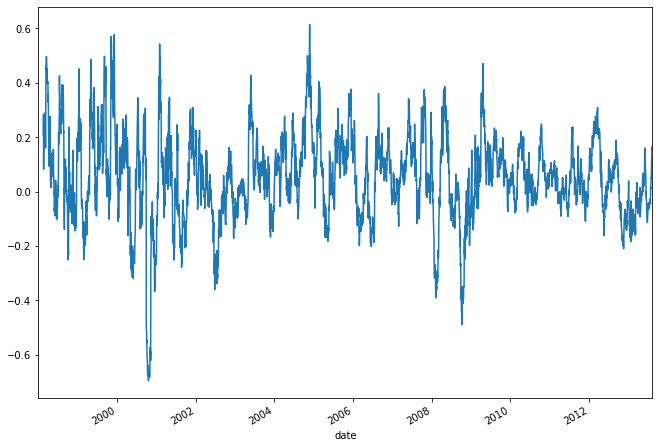

In [30]:
aapl_df.return_cumulative_30_day.plot(figsize=(11, 8))

**Notes**
- something weird is going on here with first chunk of values - check it out

#### Average

In [31]:
aapl_df["return_mean_30_day"] = aapl_df.return_daily.rolling(30).mean()

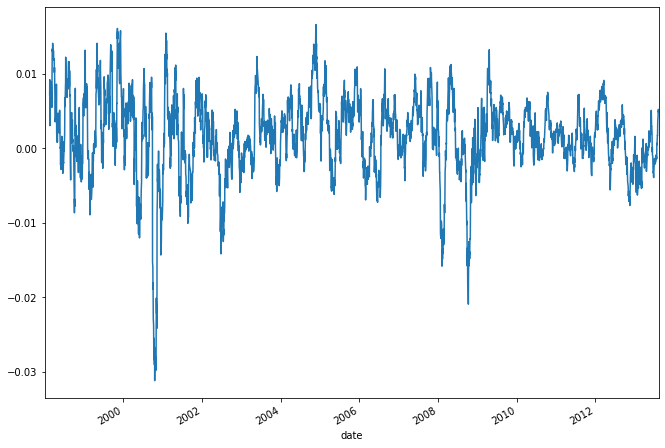

In [32]:
aapl_df.return_mean_30_day.plot(figsize=(11, 8))

#### Volatility

In [33]:
aapl_df["return_std_30_day"] = aapl_df.return_daily.rolling(30).std()

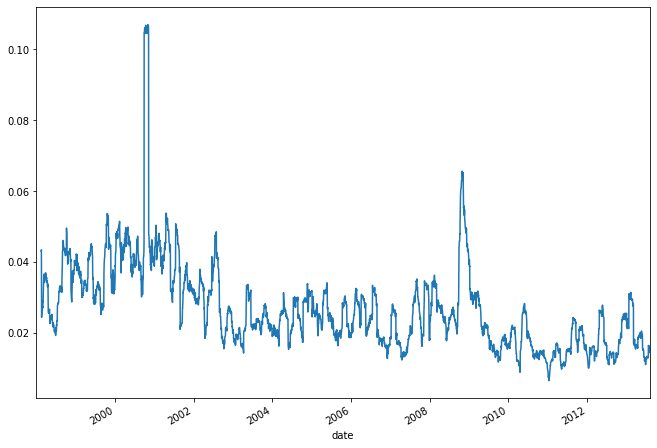

In [34]:
aapl_df.return_std_30_day.plot(figsize=(11, 8))

#### Comparisons

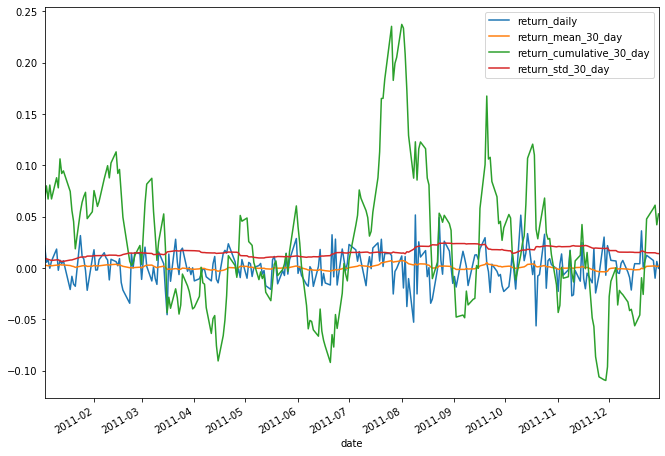

In [35]:
aapl_df.loc[
    aapl_df.year == 2011,
    ["return_daily", "return_mean_30_day", "return_cumulative_30_day", "return_std_30_day"]
            ].plot(figsize=(11, 8))

### --

### Problem

- write function to get rolling Sharpe ratios, that takes as a parameter the width of the window (in days)
- use this function to get 5, 20, and 60 day series, and plot to compare

### --

### Dummy Variables

Some data is _categorical_, or non-numeric, even if it's ordered. As such, it needs to be _one-hot encoded_ - a vector of categorical data becomes a matrix with one `bool` column for each categorical value.

#### Day of the Week

In [36]:
aapl_df["day_of_week"] = aapl_df.date.dt.dayofweek

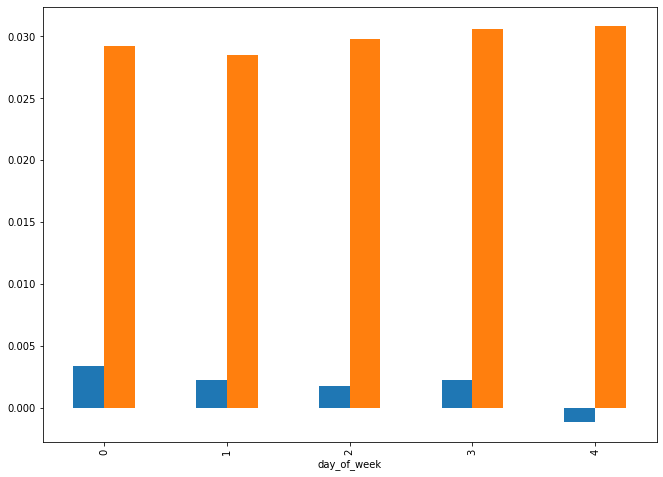

In [37]:
ax = aapl_df[
        ["return_daily", "day_of_week"]
            ].groupby(
        "day_of_week"
            ).agg(
        [np.mean, np.std]
            ).plot.bar(
        figsize=(11, 8))

ax.legend().remove()

In [38]:
d_o_w = pd.get_dummies(aapl_df.day_of_week, drop_first=True)

Note that `drop_first` means that we don't create a column for the first value, which is in this case `0` (Monday). This is because we don't want redundancy in our features - we already know that a given row represents a Monday if it is not any of Tuesday, Wednesday, Thursday, or Friday.

In [39]:
d_o_w.head()

,1,2,3,4
date,,,,
1998-01-02,0,0,0,1
1998-01-05,0,0,0,0
1998-01-06,1,0,0,0
1998-01-07,0,1,0,0
1998-01-08,0,0,1,0


In [40]:
d_o_w = d_o_w.join(aapl_df.return_daily)

We will regress simple return against day of the week - this provides an additional avenue for quantifying the relationship (and for keeping an eye out for possible features). When modeling time series data, we must *always* remember the train / test split.

In [41]:
train = d_o_w.loc[datetime.date(2012, 1, 1):datetime.date(2012, 11, 30)]

In [42]:
train.shape

(230, 5)

In [43]:
test = d_o_w.loc[datetime.date(2012, 12, 1):datetime.date(2012, 12, 31)]

In [44]:
test.shape

(20, 5)

Simply training on, and then predicting, the same set of data can work for a regression analysis.

For instance, [r squared](https://en.wikipedia.org/wiki/Coefficient_of_determination) is a performance measure that indicates how good of a job a model is doing at "explaining" the variance in the data. It is calculated as:
$$ \large 1 - \frac {\sum {(y - \hat y)^2}}{\sum {(y - \bar y)^2}}$$

This is in simple / one-predictor regression the square of the correlation between predictor and response. In multiple regression, it is the square of the coefficient of multiple correlation. So, regression analysis provides a handy and interpretable route for generating these measures.

When thinking about the performance estimation, however, you must **always** train on data that comes *before* your test data.

In [45]:
reg = LinearRegression()

In [46]:
reg = reg.fit(train.iloc[:, :4], train.return_daily)

In [47]:
reg.score(train.iloc[:, :4], train.return_daily)

0.03890481494263098

In [48]:
reg.score(test.iloc[:, :4], test.return_daily)

0.00813138843177097

### --

### Problem

- perform similar analyses for `month` and `quarter`
- feel free to experiment with the time window / testing methodology

### --

### Transformations

Sometimes, we might transform data in one way on another so as to change certain properties of the data.

For instance, a _log_ or _square-root_ transform will reduce skewness in a continuous variable - such a reduction can help bring the data closer to the underlying assumptions for a given modeling framework, which can improve prediction results. You can read more on that [here](https://otexts.com/fpp2/transformations.html).

Something often talked about in finance is _log-normal distribution of prices_, which we'll take a quick look at.

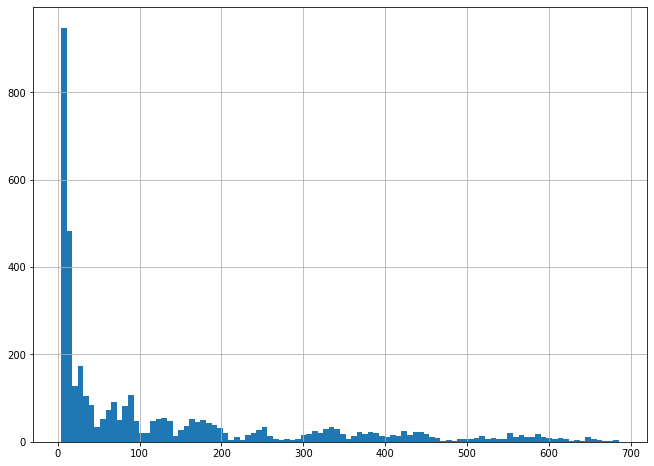

In [49]:
aapl_df.close.hist(figsize=(11, 8), bins=100)

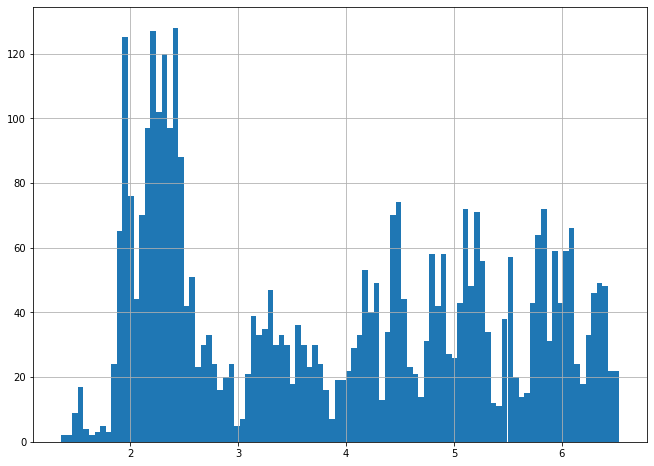

In [50]:
aapl_df.close.apply(np.log).hist(figsize=(11, 8), bins=100)

If the prices were truly log-normal, we would see _normal_ log-returns, which is not the case. Note that skewness, however, has been reduced greatly. To get log-returns, we simply take the difference between the log-price values:

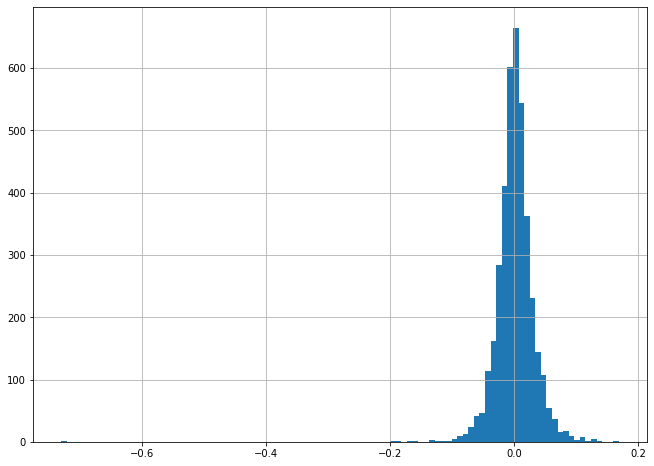

In [51]:
aapl_df.close.apply(np.log).diff().hist(figsize=(11, 8), bins=100)

# 2. First Pass at Predictive Modeling

### Classical Time Series Models

The gist of time-series modeling is that, practically speaking, you use previous values of a dataset to predict future values of it.

For instance, a simple, cross-sectional (i.e. not-time-series) modeling exercise might be to predict housing prices given the square-footage of a house. While you will likely use historical data to train your model, you are using the relevant values of a different variable, square-footage, to predict future prices, rather than using past values of the prices themselves.

This technique is known as _autoregression_ (i.e. regressing something against iteself) and the classic _AR_ [model](https://en.wikipedia.org/wiki/Autoregressive_model) provides an estimate of future values through taking the dot product of weights and the previous values of the data that they correspond to. You can fit an AR model with ordinary least squares (OLS).

The _autoregressive moving average model_ (ARMA) takes this further, and also [includes](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model) term(s) corresponding to moving / rolling averages over prior pieces of the data. One method for choosing how many lagged and MA terms to include is by looking at something called a [partial autocorrelation function](https://en.wikipedia.org/wiki/Partial_autocorrelation_function).

There are additional, "classical" variations on the basic framework that account for potential flaws in the underlying assumptions of these models. We are not really going to adhere to a classical statistics framework here but we will draw on some of the core ideas of these models as we work to, in a more "machine-learning" sort of way, engineer our own solutions.

### Basic / Benchmark Models

It's important to always have an underlying sense of what your benchmark / default might be when modeling - you never want to think about your predictions as if they exist in some sort of vacuum. We will start with a couple of basic, dummy models to test.

Note that these will work terribly on the data we're working with - stocks are hard to predict, and using one only one month for testing is not a good approach for really validating a model. There are plenty of time series datasets for which doing something really simple will yield better results.

In [52]:
train = train.return_daily

In [53]:
test = test.return_daily

#### Average

In [54]:
model = lambda: train.mean()

In [55]:
model()

0.0017979570942215008

In [56]:
y_pred = pd.Series([model() for _ in range(test.shape[0])], index=test.index)

In [57]:
r2_score(test, y_pred)

-0.07597763639405897

In [58]:
y_pred

date
2012-12-03    0.001798
2012-12-04    0.001798
2012-12-05    0.001798
2012-12-06    0.001798
2012-12-07    0.001798
2012-12-10    0.001798
2012-12-11    0.001798
2012-12-12    0.001798
2012-12-13    0.001798
2012-12-14    0.001798
2012-12-17    0.001798
2012-12-18    0.001798
2012-12-19    0.001798
2012-12-20    0.001798
2012-12-21    0.001798
2012-12-24    0.001798
2012-12-26    0.001798
2012-12-27    0.001798
2012-12-28    0.001798
2012-12-31    0.001798
dtype: float64

#### Naive

In [59]:
r2_score(test.iloc[1:], test.shift(1).iloc[1:])

-1.0085314567136514

### Partial Autocorrelation

With _partial autocorrelation_, we look seek to identify the autocorrelation that is unique to a particular lag - i.e. we control for the autocorrelation of other lagged variables. You can read more on that [here](https://towardsdatascience.com/understanding-partial-auto-correlation-fa39271146ac). This can be a nice method for identifying useful lags for modeling.

In [61]:
partial_auto = pd.Series(pacf(aapl_df.return_daily.dropna(), nlags=90))

In [62]:
partial_auto.index.name = "lags"

In [72]:
partial_auto = partial_auto.iloc[1:]

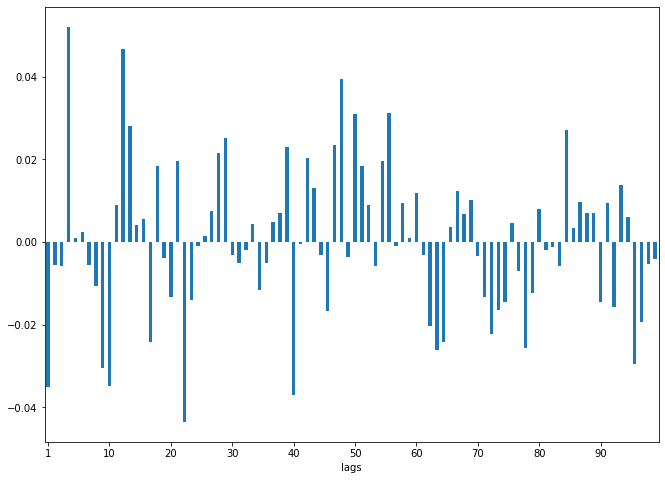

In [73]:
ax = partial_auto.plot.bar(figsize=(11, 8), rot=0)
plt.locator_params(nbins=10)
xlab = ax.set_xticklabels((1, 10, 20, 30, 40, 50, 60, 70, 80, 90))

### Feature Engineering

Let's write some functionality to help us create lagged variables.

In [39]:
def get_shifted(srs, shift_start, shift_end):
    """
    Returns a df, with each column corresponding to `srs` being shifted,
    starting with `shift_start` number of shifts and going through
    `shift_end`.
    """
    return pd.concat([
                        srs.shift(i).rename(f"{srs.name}_shifted_{i}")
                        for i in range(shift_start, shift_end + 1)
            ], axis=1)

In [41]:
aapl_features = get_shifted(aapl_df.return_daily, 1, 21)

In [42]:
aapl_features.shape

(3926, 21)

In [45]:
aapl_features = aapl_features.join(
                    aapl_df[[
                        "return_daily_rolling_21",
                        "return_daily_rolling_63",
                        "return_vol_rolling_63"
                    ]])

In [46]:
aapl_features.shape

(3926, 24)

In [47]:
aapl_features = aapl_features.join(aapl_df.month)

### Train / Test

In [48]:
train = aapl_df.loc[
                (aapl_df.year == 2009)
                &
                (aapl_df.month < 10)
                    ].index

In [49]:
test = aapl_df.loc[
                (aapl_df.year == 2009)
                &
                (aapl_df.month >= 10)
                    ].index

In [50]:
X_train = aapl_features.loc[train]

In [51]:
X_test = aapl_features.loc[test]

In [52]:
y_train = aapl_df.loc[train, "return_daily"]

In [53]:
y_train.shape

(188,)

In [54]:
y_test = aapl_df.loc[test, "return_daily"]

In [55]:
y_test.shape

(64,)

In [56]:
aapl_features.columns.tolist()

['return_daily_shifted_1',
 'return_daily_shifted_2',
 'return_daily_shifted_3',
 'return_daily_shifted_4',
 'return_daily_shifted_5',
 'return_daily_shifted_6',
 'return_daily_shifted_7',
 'return_daily_shifted_8',
 'return_daily_shifted_9',
 'return_daily_shifted_10',
 'return_daily_shifted_11',
 'return_daily_shifted_12',
 'return_daily_shifted_13',
 'return_daily_shifted_14',
 'return_daily_shifted_15',
 'return_daily_shifted_16',
 'return_daily_shifted_17',
 'return_daily_shifted_18',
 'return_daily_shifted_19',
 'return_daily_shifted_20',
 'return_daily_shifted_21',
 'return_daily_rolling_21',
 'return_daily_rolling_63',
 'return_vol_rolling_63',
 'month']

### Additional Prep

In [57]:
X_train.dtypes.value_counts()

float64    24
int64       1
dtype: int64

In [58]:
scaler = StandardScaler()

In [59]:
float_cols = X_train.select_dtypes(include=float).columns

In [60]:
X_train.loc[:, float_cols] = scaler.fit_transform(X_train.loc[:, float_cols])

In [61]:
X_test.loc[:, float_cols] = scaler.fit_transform(X_test.loc[:, float_cols])

### `LinearRegression` 

In [63]:
linreg = LinearRegression()

In [64]:
linreg = linreg.fit(X_train, y_train)

In [65]:
linreg.score(X_train, y_train)

0.9480997046474106

In [66]:
linreg.score(X_test, y_test)

-1.1086292410723533

### `Ridge` 
- in *Ridge regression*, something called *L2 normalization* is applied
- [this](https://en.wikipedia.org/wiki/Tikhonov_regularization) will force coefficients to stay close to 0, which helps to prevent overfitting
- in `sklearn`, we control this value with the `alpha` hyper parameter
- the higher the value of `alpha`, the higher the regularization; tuning in powers of ten is common

In [67]:
ridge = Ridge(alpha=10)

In [68]:
ridge = ridge.fit(X_train, y_train)

In [69]:
ridge.score(X_train, y_train)

0.5620129221780635

In [70]:
ridge.score(X_test, y_test)

0.4570863648300462

### Visualize Predictions

In [71]:
y_test_pred = ridge.predict(X_test)

In [72]:
y_test = y_test.rename("y_test").to_frame()

In [73]:
y_test["y_pred"] = y_test_pred

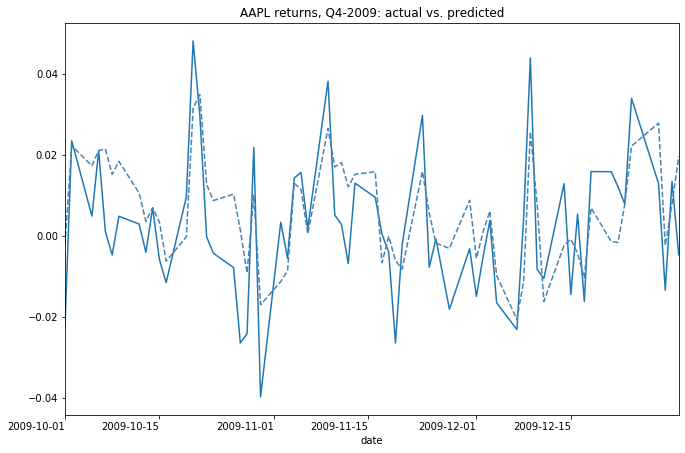

In [74]:
ax = y_test.y_test.plot(figsize=(11, 8), rot=0)
ax = y_test.y_pred.plot(ax=ax, color="steelblue", linestyle="--", rot=0)
t = ax.title.set_text("AAPL returns, Q4-2009: actual vs. predicted")

# 3. Walk-Forward Validation

Just as in cross-sectional modeling, where *cross validation* is used, we want unbiased estimations of model performance. In time-series modeling, however, we need to be very careful not to leak data, which can be easy to do when there is a strict chronology. So, we run train / test splits over different parts of the data, where train _always_ comes before test.

Specifically:

- we run run a number of trials of this splitting on a validation part of the data
- this is where we make decisions around features to use, hyper-parameter tuning, etc.
- then, on a _later_ chunk of the data, we'll run some more trials, where we make no changes, and these are the numbers we report
- we can use 3, 5, 10, etc. trials in each of the validation and test sets, just like in classic CV
- and we use the mean (and maybe, standard deviation) across these trials for our decision making and results reporting


### --

### Problem

- write a program to perform walk-forward validation
- use this program to help you in your model selection
- i.e. in selecting features to use, hyper-parameter values to set

The core functionality should work as follows. It should take as parameters something like:
- `model_obj`
- `data`
- `X_cols`
- `y_col`
- `start_year`
- `start_quarter`
- `num_trials=3`

and then, using that information, it's going to run `num_trials` trials, each of which should work as follows:
- grab the next year's worth (4 quarters) of data
- take the first 3 quarters for training, and the final quarter for testing
- train the model on the training data
- predict based on the test data
- retain both the actual test values and predicted ones

At the end of each iteration, the program will shift it's one-year window ahead by one quarter, so that the earliest quarter in the training data is dropped out, the test data becomes the last quarter in the training data, and a new test quarter is chosen.

The total length of the data evaluated is *1 year plus (`num_trials` - 1) quarters*. The program should return a `DataFrame` with columns `y_test` and `y_pred` with the date of each prediction in the index.

That process will be the same for each of the validation and reporting chunks. Remember that there are _two_ layers of splitting; this functionality is for the inner layer. If you want to wrap this in something to handle the outer layer as well, you can, but start with the inner layer.

### --

In [79]:
results = time_series_validation(
                                   Ridge(alpha=10),
                                   aapl_df,
                                   X_cols=aapl_features.columns,
                                   y_col="return_daily",
                                   start_year=2008,
                                   start_quarter=2
                            )

In [80]:
results.head()

,y_test,y_pred
date,,
2009-01-02,0.056930,0.012667
2009-01-05,0.043378,0.006848
2009-01-06,-0.016503,-0.014871
2009-01-07,-0.022481,-0.024702
2009-01-08,0.019147,-0.010358


In [81]:
results.tail()

,y_test,y_pred
date,,
2009-09-24,-0.007556,-0.012156
2009-09-25,-0.008754,-0.014186
2009-09-28,0.020899,0.016828
2009-09-29,-0.004889,-0.005245
2009-09-30,-0.000921,-0.006902


In [85]:
results = results.sort_index()

In [86]:
r2_score(results.y_test, results.y_pred)

0.32267887538275086

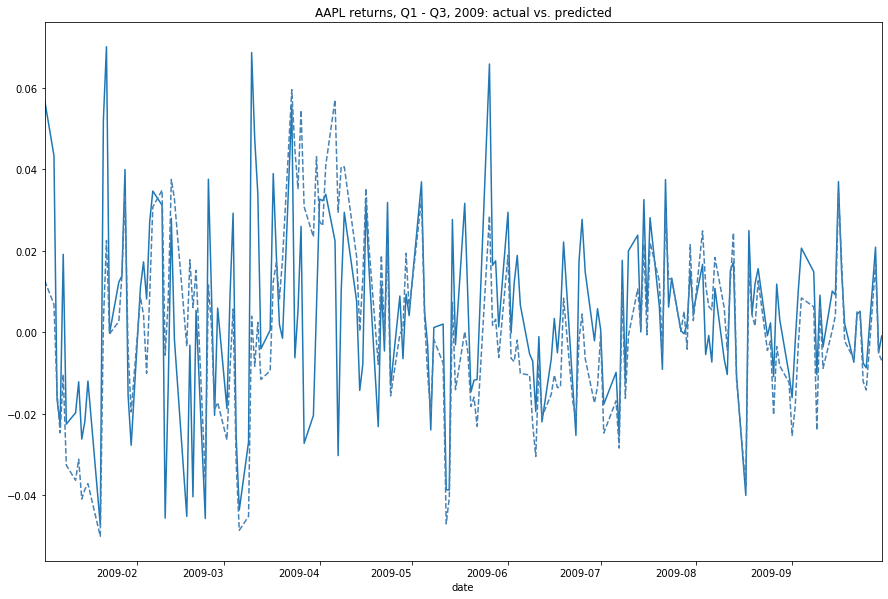

In [84]:
ax = results.y_test.plot(figsize=(15, 11), rot=0)
ax = results.y_pred.plot(ax=ax, color="steelblue", linestyle="--", rot=0)
t = ax.title.set_text("AAPL returns, Q1 - Q3, 2009: actual vs. predicted")

In [87]:
results = results.reset_index()

In [88]:
results["month"] = results.date.dt.month

In [89]:
results = results.set_index("date", drop=False)

In [90]:
results.head()

,date,y_test,y_pred,month
date,,,,
2009-01-02,2009-01-02,0.056930,0.012667,1
2009-01-05,2009-01-05,0.043378,0.006848,1
2009-01-06,2009-01-06,-0.016503,-0.014871,1
2009-01-07,2009-01-07,-0.022481,-0.024702,1
2009-01-08,2009-01-08,0.019147,-0.010358,1


In [91]:
r2_by_month = results.groupby(
                        "month"
                    )[
                        ["y_test", "y_pred"]
                    ].apply(
                        lambda x: r2_score(x["y_test"], x["y_pred"])
                    ).rename(
                        "r2_score"
                    ).to_frame()

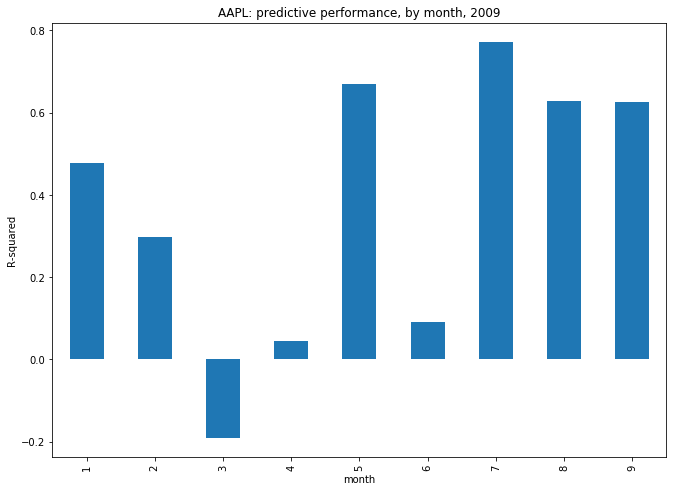

In [92]:
ax = r2_by_month.plot.bar(figsize=(11, 8))
t = ax.title.set_text("AAPL: predictive performance, by month, 2009")
ylab = ax.set_ylabel("R-squared")
l = ax.legend().remove()

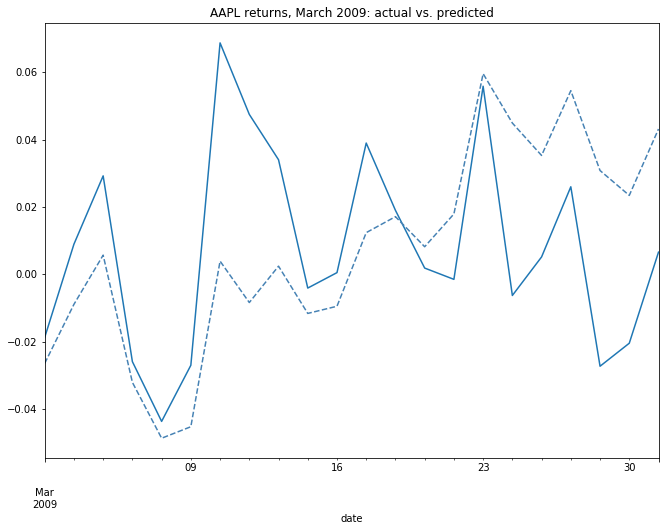

In [83]:
ax = results.loc[results.month==3, "y_test"].plot(figsize=(11, 8), rot=0)
ax = results.loc[results.month==3, "y_pred"].plot(ax=ax, color="steelblue", linestyle="--", rot=0)
t = ax.title.set_text("AAPL returns, March 2009: actual vs. predicted")

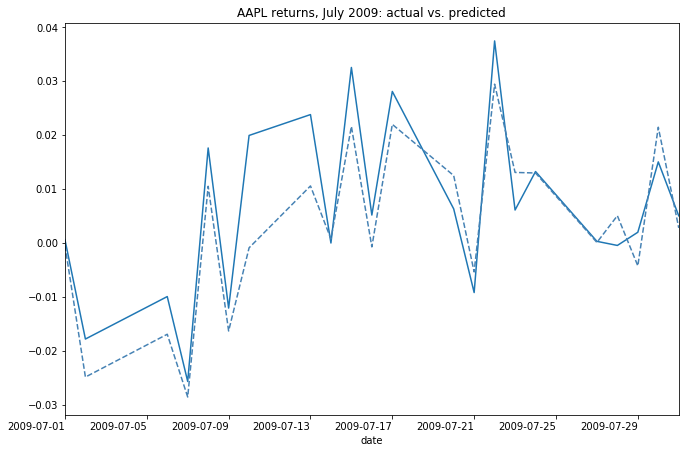

In [84]:
ax = results.loc[results.month==7, "y_test"].plot(figsize=(11, 8), rot=0)
ax = results.loc[results.month==7, "y_pred"].plot(ax=ax, color="steelblue", linestyle="--", rot=0)
t = ax.title.set_text("AAPL returns, July 2009: actual vs. predicted")

In [93]:
results2 = time_series_validation(
                                   Ridge(alpha=10),
                                   aapl_df,
                                   X_cols=aapl_features.columns,
                                   y_col="return_daily",
                                   start_year=2010,
                                   start_quarter=1,
                                   num_trials=4
                            )

In [94]:
results2 = results2.sort_index()

In [95]:
r2_score(results2.y_test, results2.y_pred)

-0.015111392971006055

# 4. Beat My *R-Squared*

### A.

Through experimenting with different feature sets, and at least one other model, try to beat the above, aggregate *R-squared* (.32) over the same test periods.

### B.

Analyze the monthly performance of the model, and compare and contrast its performance to what I developed above.

### C.

Test both your new model and my previous model (`Ridge(alpha=10)`, with `aapl_features` as features) on a *new* test period, which will start at year 2009 and quarter 2: 
- which model provides a better, overall *r-squared*?
- which model provides more _consistency_ on a month-to-month basis (please quantify)?
- which model would you choose?